In [30]:

import torchvision
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from sklearn.decomposition import PCA 
import math
from tqdm import tqdm

MAX_ITER = 100
EPSILON = 1e-10
TOLERANCE = 1e-5

class GMM:
    def __init__(self, K, d):
        self.K_RANGE = K

        np.random.seed(0)
        pi = np.random.rand(K)
        self.pi = pi / np.sum(pi)

        np.random.seed(0)
        self.mu = np.random.normal(0, 3, size=(K, d))

        np.random.seed(0)
        self.S = np.random.rand(K, d) + 0.5

    def EM_STEP(self, X):
        N, d = X.shape
        log_r = np.zeros((N, self.K_RANGE))
        loss = []

        for iter in range(MAX_ITER):
            for k in range(self.K_RANGE):
                log_r[:,k] = np.log(self.pi[k] + EPSILON) - 0.5 * np.sum(np.log(self.S[k] + EPSILON)) - 0.5 * np.dot((X-self.mu[k]) ** 2, 1/(self.S[k] + EPSILON))
            
            log_r_i = logsumexp(log_r, axis = 1)
            log_r = log_r - log_r_i[:,None]
            loss.append(-np.sum(log_r_i))

            if iter > 1 and abs(loss[iter] - loss[iter-1]) <= TOLERANCE * abs(loss[iter]):
                break

            r = np.exp(log_r)
            r_dot_k = np.sum(r, axis = 0)
            self.pi = r_dot_k / N
            self.mu = np.matmul(r.T, X) / (r_dot_k[:,None] + EPSILON)
            self.S = np.matmul(r.T, X**2) / (r_dot_k[:,None] + EPSILON) - self.mu ** 2

        return loss
    
    def sort_models(self):
        indices = np.argsort(self.pi)
        self.pi, self.mu, self.S = self.pi[indices], self.mu[indices], self.S[indices]

    def p_theta(self, X):
        p = 0
        for k in range(self.K_RANGE):
            exp_power = -0.5 * np.dot((X-self.mu[k]) ** 2, 1/(self.S[k] + EPSILON))
            p += self.pi[k] * np.power(np.product(self.S[k]) * 2 * math.pi + EPSILON, -0.5) * np.exp(exp_power)
        return p
    
    def __str__(self):
        ret = "GMM Model with K = {}\n".format(self.K_RANGE)

        ret += "Weights: {}\n".format(self.pi)

        ret += "Means: {}\n".format(self.mu)

        ret += "Diagonal Covariance: {}\n".format(self.S)
        return ret
transform = transforms.Compose([transforms.ToTensor()])


training GMM with k = 0
training GMM with k = 1
training GMM with k = 2
training GMM with k = 3
training GMM with k = 4
training GMM with k = 5
training GMM with k = 6
training GMM with k = 7
training GMM with k = 8
training GMM with k = 9


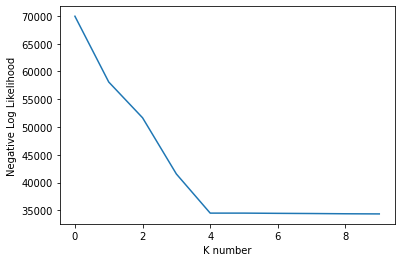

In [20]:
X = np.loadtxt(open("gmm_dataset.csv", "rb"), delimiter=",")
n, d = X.shape
MAX_K = 10
models, losses = [None] * MAX_K, [None] * MAX_K
for k in range(10):
    print(f"training GMM with k = {k}")
    model = GMM(k+1, d)
    loss = model.EM_STEP(X)
    models[k] = model
    losses[k] = loss[-1]

plt.plot(losses)
plt.xlabel("K number")
plt.ylabel("Negative Log Likelihood")
plt.savefig("gmm_loss.png")
plt.show()

In [23]:
choose_of_k = 4

print(f"Choose k to be {choose_of_k}")

chosen_model = models[choose_of_k-1]
chosen_model.sort_models()
print(chosen_model)



Choose k to be 4
GMM Model with K = 4
Weights: [0.09993414 0.20025588 0.29999657 0.39981342]
Means: [[-2.5627181   0.60337574  0.90745592 -0.71058093  2.30680375 -1.43918693
   0.06328725 -0.18376917  1.52080393  1.47012393  0.13393887  0.40621831
  -0.85450408 -1.97701398 -0.32135938  0.18280744  1.22269799  1.21377036
  -0.44258832 -0.32101564]
 [-1.03907932 -1.39295214 -1.70760377  1.91703835 -0.53885794 -0.44294692
  -1.27312439  0.76609747 -1.57490745 -0.22055584 -0.89470626  0.3886911
  -0.53610847 -1.1641861  -0.04052967  0.44047057  0.04808813  0.30118042
  -0.65212051 -0.34941147]
 [-0.66420197 -0.39858852 -0.83831472 -1.71763564  0.18915297 -0.37076055
  -1.64449944  0.47975999 -0.94519576  0.03328255  0.7486806   0.09162917
   1.14866329 -1.21051607  0.43646497 -0.70271377 -0.89330026 -0.57061029
  -0.31965039  0.05544879]
 [-0.44528199  0.80371051  0.60120252 -0.57745704  1.60198765  1.20713514
   1.12312928 -0.18323747 -0.81467637  0.90340714 -0.24046742  1.26898839
   0.3

# QUESTION2 MNIST

In [24]:
root = './data'
train_data = datasets.MNIST(root = root, train= True, transform=None, download=True)
test_data = datasets.MNIST(root = root, train= False, transform=None, download=True)

train_N, d1, d2 = train_data.data.shape
train_X = np.reshape(train_X, (train_N, d1 * d2))
train_Y = train_data.targets.numpy()

test_N, d1, d2 = test_data.data.shape
test_X = np.reshape(test_X, (test_N, d1 * d2))
test_Y = test_data.targets.numpy()

d = 40

reducer = PCA(n_components=d)
reducer.fit(train_X)

train_data_reduced = reducer.transform(train_X)
test_data_reduced = reducer.transform(test_X)

torch.Size([60000, 28, 28])


In [28]:
def split_training_set(train_x, train_y):
    train_x_split = [[] for _ in range(10)]
    for i in range(len(train_y)):
        train_x_split[train_y[i]].append(train_x[i])
    return train_x_split

def train_baysianGMM(train_x, train_y, k):
    gmms = []
    d = len(train_x[0])

    train_x_by_classes = split_training_set(train_x, train_y)

    # Calculate P(Y=c)
    total = len(train_x)
    P_yc = []
    for x_c in train_x_by_classes:
        P_yc.append(len(x_c)/total)

    print("------- Training ------")
    # Train gmm for each class
    for c in tqdm(range(len(train_x_by_classes))):
        train_x_class_c = np.array(train_x_by_classes[c])
        gmm_c = GMM(k, d)
        gmm_c.EM_STEP(train_x_class_c)
        gmms.append(gmm_c)

    return gmms, P_yc

def baysianGMM_classifier(x, gmms, P_yc):
    largest_prob = -1
    chosen_c = -1
    for c in range(len(gmms)):
        gmm_c = gmms[c]
        prob = gmm_c.p_theta(x) * P_yc[c]
        if prob > largest_prob:
            largest_prob = prob
            chosen_c = c
    
    return chosen_c

def report_test_err(test_X, test_Y, gmms, P_yc):
    pred_Y = []
    print("------- Testing ------")
    for x in tqdm(test_X):
        y_hat = baysianGMM_classifier(x, gmms, P_yc)
        pred_Y.append(y_hat)

    err_count = 0
    for y_hat, y in zip(pred_Y, test_Y):
        if y_hat != y:
            err_count += 1
    
    return err_count/len(test_Y)

def train_and_test(train_data, train_label, test_data, test_label):
    err_list = []
    for k in (range(1, 11)):
        print("============= Train and Test for k =", k, "===============")
        gmms, p_yc= train_baysianGMM(train_data, train_label, k)
        err = report_test_err(test_data, test_label, gmms, p_yc)
        err_list.append(err)
        print("For k=", k, "Error is:", err)


    return err_list

In [31]:
err_list = train_and_test(train_data_reduced, train_Y, test_data_reduced, test_Y)

============= Train and Test for k = 1 ===============
------- Training ------


100%|██████████| 10/10 [00:00<00:00, 163.90it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:01<00:00, 8596.52it/s]


For k= 1 Error is: 0.125
============= Train and Test for k = 2 ===============
------- Training ------


100%|██████████| 10/10 [00:00<00:00, 16.95it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:02<00:00, 4487.32it/s]


For k= 2 Error is: 0.112
============= Train and Test for k = 3 ===============
------- Training ------


100%|██████████| 10/10 [00:00<00:00, 11.07it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:03<00:00, 3025.96it/s]


For k= 3 Error is: 0.0917
============= Train and Test for k = 4 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  8.93it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:04<00:00, 2268.61it/s]


For k= 4 Error is: 0.0892
============= Train and Test for k = 5 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:05<00:00, 1828.41it/s]


For k= 5 Error is: 0.0866
============= Train and Test for k = 6 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:06<00:00, 1522.89it/s]


For k= 6 Error is: 0.0778
============= Train and Test for k = 7 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:07<00:00, 1304.85it/s]


For k= 7 Error is: 0.0751
============= Train and Test for k = 8 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:08<00:00, 1142.99it/s]


For k= 8 Error is: 0.0709
============= Train and Test for k = 9 ===============
------- Training ------


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:09<00:00, 1016.45it/s]


For k= 9 Error is: 0.0689
============= Train and Test for k = 10 ===============
------- Training ------


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:10<00:00, 914.96it/s]

For k= 10 Error is: 0.0704


In [ ]:



np.sum(r[:, k, np.newaxis] * X * X, axis = 0) / (rsum[k] + eps) - means[k, :] * means[k, :]

In [118]:
N, K, D = 5,3,4

means = np.zeros((K,D))
means[[0,1], :] = np.array([[1,2,3,4], [6,7,8,9]])
print(means)
means[1,:] * means[1, :]

r = np.array([[1,2,3,4,8],[6,2,2,3,1],[1,2,3,4,5]]).T
print(r)
X = np.array([[1,0,3,7],[2,0,4,7],[3,0,9,2],[4,0,5,1],[5,0,9,2]])
print(X)

r[:, 0, None]

[[1. 2. 3. 4.]
 [6. 7. 8. 9.]
 [0. 0. 0. 0.]]
[[1 6 1]
 [2 2 2]
 [3 2 3]
 [4 3 4]
 [8 1 5]]
[[1 0 3 7]
 [2 0 4 7]
 [3 0 9 2]
 [4 0 5 1]
 [5 0 9 2]]


array([[1],
       [2],
       [3],
       [4],
       [8]])